<a href="https://www.kaggle.com/code/hamidjalili/disney-stock-price-prediction?scriptVersionId=96780468" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

In [2]:
np.random.seed(123)
tf.random.set_seed(456)

&emsp; The DJIA 30 Stock Series is a list of historical stock prices from 2006 to 2018 on 29 of 30 DJIA (Dow Jones Industrial Average) companies. This includes Apple, Microsoft, Walmart, Goldman Sachs, etc. Each company has the following list of colums:

<b>Date</b> - in format: yy-mm-dd

<b>Open</b> - price of the stock at market open (this is NYSE data so all in USD)

<b>High</b> - Highest price reached in the day

<b>Low Close</b> - Lowest price reached in the day

<b>Volume</b> - Number of shares traded

<b>Name</b> - the stock's ticker name

&emsp; The goal of this forecast is to predict the daily stock Highs of a DIJA company in 2017 using the previous years and Deep Learning models. The particular company I have chosen for this data set is Disney. The forecast models used are a simple Recurrent Neural Network (RNN) and a Long Term Short Memory (LSTM). The results of the predicted model and the actual prices will be overlayed with each other to compare the performance. The root mean square will also be used to evaluate the models.

In [3]:
df = pd.read_csv('/kaggle/input/stock-time-series-20050101-to-20171231/DIS_2006-01-01_to_2018-01-01.csv', index_col='Date',parse_dates=['Date']) #../input/stock-time-series-20050101-to-20171231

In [4]:
df.shape

(3020, 6)

In [5]:
df.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,24.08,24.48,24.00,24.40,9657400,DIS
2006-01-04,24.50,24.69,23.77,23.99,13165300,DIS
2006-01-05,24.13,24.69,24.10,24.41,8698200,DIS
2006-01-06,24.65,24.79,24.44,24.74,6412800,DIS
2006-01-09,24.85,25.03,24.72,25.00,6590300,DIS


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3018 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3018 non-null   float64
 3   Close   3020 non-null   float64
 4   Volume  3020 non-null   int64  
 5   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.2+ KB


There seems to be some missing values in the data set; interpolation will be used to fill these in

# Data Cleaning

#### Fill in missing values

In [7]:
df.isnull().sum()

Open      2
High      1
Low       2
Close     0
Volume    0
Name      0
dtype: int64

In [8]:
# 'ffill': propagate last valid observation forward to next valid backfill
df = df.fillna(method='ffill')
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

#### Train\Test Split

In [9]:
training_set = df[:'2016'].iloc[:,1:2].values
test_set = df['2017':].iloc[:,1:2].values

# Data Visualization

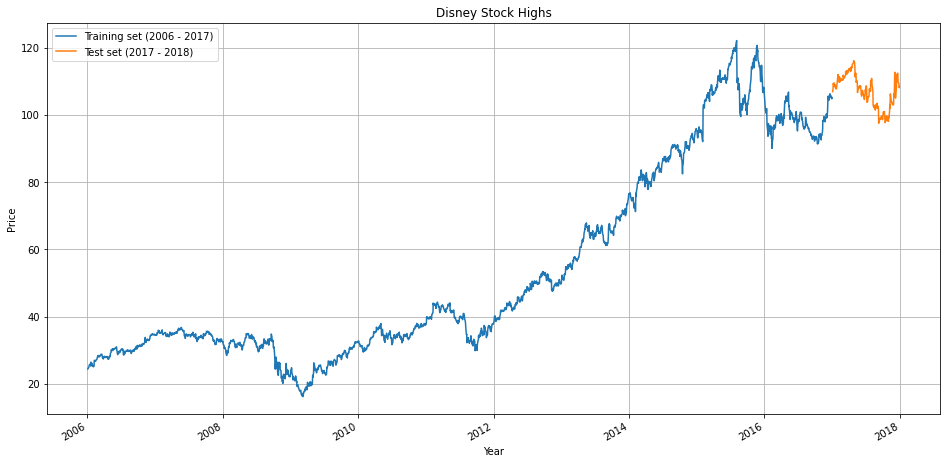

In [10]:
# Plot of full time series feature 'Highs'
plt.figure(figsize = (14,7))
ax = plt.axes()
df["High"][:'2016'].plot(figsize=(16,8))
df["High"]['2017':].plot(figsize=(16,8))
ax.set_title('Disney Stock Highs')
ax.set_xlabel('Year')
ax.set_ylabel('Price')
plt.legend(["Training set (2006 - 2017)", "Test set (2017 - 2018)"])
ax.grid(True)
plt.show()

# Data Preprocessing

The Hyperparameters below were chosen based on some trial and error behind the scenes

#### Hyperparameters

In [11]:
cell_units = 50
Dropout_Rate = 0.1
epoch = 50
timesteps = 50

#### Scaling the data

In [12]:
# Fit/Transform the Training Set
mm = MinMaxScaler()
training_set = mm.fit_transform(training_set)

#### Prepare Training Data for Keras

In [13]:
# We create a data structure with x_number of  timesteps and 1 output
# So for each element of training set, we have x_number of previous training set elements 
X_train = []
y_train = []
for i in range(timesteps,len(training_set)-1):
    X_train.append(training_set[i-timesteps:i,0])
    y_train.append(training_set[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
# Must reshape input for Keras to accept it
print('Training input before reshape: {}'.format(X_train.shape))
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print('Training input after reshape:  {}'.format(X_train.shape))

Training input before reshape: (2718, 50)
Training input after reshape:  (2718, 50, 1)


#### Prepare Test Data for Keras

In [15]:
# Now to get the test set ready in a similar way as the training set.
# Need test set values and some (timesteps number) previous data points from the non-scaled training set for processing
inputs = df['High'][len(df)-len(test_set) - timesteps:].values
inputs = inputs.reshape(-1,1)
inputs  = mm.transform(inputs)

In [16]:
# Preparing X_test
X_test = []
for i in range(timesteps,len(test_set)+timesteps):
    X_test.append(inputs[i-timesteps:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

#### Create functions to display results

In [17]:
# Results
def plot_prediction(test,predicted):
    plt.plot(test, color='red',label='Real Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Stock Price')
    plt.title('Disney Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# RNN Model

&emsp; Our first model will be a simple RNN with 3 layers using 'relu' activation functions, 'mean_squared_error' loss function, and an 'adam' optimizer. Per hidden layer there are 50 hidden values and 50 iterations will be done for optimization.

In [18]:
# initialize RNN model
model_RNN = Sequential() 
    
# Layer 1
model_RNN.add(SimpleRNN(cell_units, input_shape=(X_train.shape[1],1)))

# Layer 2
model_RNN.add(Dense(cell_units, activation="relu"))

# Layer 3
model_RNN.add(Dense(cell_units, activation="relu"))
   
# Output
model_RNN.add(Dense(1))

2022-05-27 19:37:23.974631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:37:24.102481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:37:24.103384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 19:37:24.104613: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [19]:
# define the loss function / optimization strategy, and fit the model with the desired epochs
model_RNN.compile(loss='mean_squared_error', optimizer='adam')
model_RNN.fit(X_train,y_train,epochs=epoch,batch_size=32, verbose=0)

2022-05-27 19:37:27.128326: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


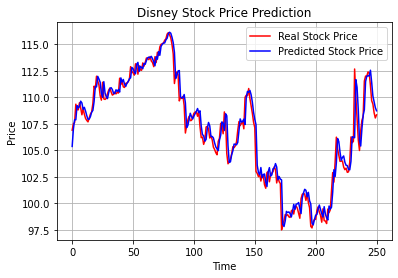

The root mean squared error is 1.069094708126537.


In [20]:
# Predicting the prices
y_pred = model_RNN.predict(X_test)
y_pred = mm.inverse_transform(y_pred)

plot_prediction(test_set,y_pred)
return_rmse(test_set,y_pred)

We see that this models predictions are very close to the actual stock prices. We will now move onto the LSTM model.

# LSTM Model

&emsp; The LSTM model will also have 3 layers and the same optimizer and loss function. The amount of hidden states is the same as before as well as well as the number of iterations. Dropout, a regularization term, will be used with a value of 0.1 in each layer. 

In [21]:
## Initialize LSTM Model
model_LSTM = Sequential()

# Layer 1 with regularization/dropout
model_LSTM.add(LSTM(units=cell_units,return_sequences=True,input_shape=(X_train.shape[1],1)))
model_LSTM.add(Dropout(Dropout_Rate))

# Layer 2 with regularization/dropout
model_LSTM.add(LSTM(units=cell_units,return_sequences=True))
model_LSTM.add(Dropout(Dropout_Rate))

# Layer 3 with regularization/dropout
model_LSTM.add(LSTM(units=cell_units))
model_LSTM.add(Dropout(Dropout_Rate))

# Output
model_LSTM.add(Dense(units=1))

In [22]:
# define the loss function / optimization strategy, and fit the model with the desired epochs
model_LSTM.compile(optimizer='adam',loss='mean_squared_error')
model_LSTM.fit(X_train,y_train,epochs=epoch,batch_size=32, verbose=0)

2022-05-27 19:39:51.510531: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


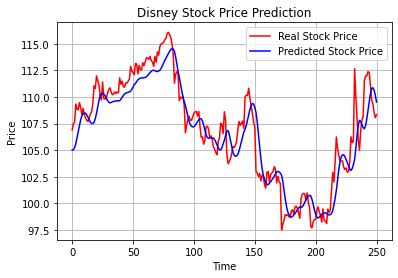

The root mean squared error is 1.8316753359581484.


In [23]:
# Predicting the prices
y_pred = model_LSTM.predict(X_test)
y_pred = mm.inverse_transform(y_pred)

plot_prediction(test_set,y_pred)
return_rmse(test_set,y_pred)

&emsp; This model seems to have performed worse than the simple RNN. A reason for this may be due to the regularization term as the predictions seem to be underfitting the testing set. 

# LSTM Model 2

&emsp; The previous LSTM model will be run again, but without the dropout terms

In [24]:
## Initialize LSTM Model
model_LSTM_2 = Sequential()

# Layer 1
model_LSTM_2.add(LSTM(units=cell_units,return_sequences=True,input_shape=(X_train.shape[1],1)))

# Layer 2
model_LSTM_2.add(LSTM(units=cell_units,return_sequences=True))

# Layer 3
model_LSTM_2.add(LSTM(units=cell_units))

# Output
model_LSTM_2.add(Dense(units=1))

In [25]:
# define the loss function / optimization strategy, and fit the model with the desired epochs
model_LSTM_2.compile(optimizer='adam',loss='mean_squared_error')
model_LSTM_2.fit(X_train,y_train,epochs=epoch,batch_size=32, verbose=0)

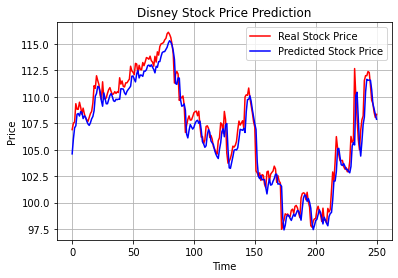

The root mean squared error is 1.205237976963776.


In [26]:
# Predicting the prices
y_pred = model_LSTM_2.predict(X_test)
y_pred = mm.inverse_transform(y_pred)

plot_prediction(test_set,y_pred)
return_rmse(test_set,y_pred)

&emsp; Although still not as great as the simple RNN, it performed better than last time 

&emsp; We see from these results that the simple RNN model performed the best and the LSTM without regularization performed much better than the one with it. In this case, The simple RNN is clearly the best model as it gave better results and it trained much faster than either LSTM model.